In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


In [3]:
def split_data(df, choose):
  if choose == 1: # 7:2:1
    train_size = int(len(df) * 0.7)
    test_size = int(len(df) * 0.2)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]
  elif choose == 2: # 6:3:1
    train_size = int(len(df) * 0.6)
    test_size = int(len(df) * 0.3)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]
  elif choose == 3: # 5:3:2
    train_size = int(len(df) * 0.5)
    test_size = int(len(df) * 0.3)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]


  print("Train: ", train_size)
  print("Test: ", test_size)
  print("Val: ", val_size)
 
  return train_data, test_data, val_data

In [56]:
df = pd.read_csv('/content/drive/MyDrive/IS403.N22/Project/dataset/TSLA_Stock.csv')#, parse_dates=['Date'], index_col='Date')
df

,Date,Price
0,2018-01-02,21.37
1,2018-01-03,21.15
2,2018-01-04,20.97
3,2018-01-05,21.11
4,2018-01-08,22.43
...,...,...
1330,2023-04-17,187.04
1331,2023-04-18,184.31
1332,2023-04-19,180.59
1333,2023-04-20,162.99


In [27]:
def get_feature_RollingWindow(df, window_size = 7):
  rolling_window = df['Price'].rolling(window=window_size)
  df['mean'] = rolling_window.mean()
  df['std'] = rolling_window.std()
  df['min'] = rolling_window.min()
  df['max'] = rolling_window.max()

  # Loại bỏ các dòng có giá trị NaN sau khi tính toán
  df.dropna(inplace=True)
  df = df.reset_index(drop=True)
  
  return df

df = get_feature_RollingWindow(df, window_size = 7)
df

,Date,Price,mean,std,min,max
0,2018-01-10,22.32,21.657143,0.645412,20.97,22.43
1,2018-01-11,22.53,21.822857,0.705519,20.97,22.53
2,2018-01-12,22.41,22.002857,0.664799,20.97,22.53
3,2018-01-16,22.67,22.245714,0.519161,21.11,22.67
4,2018-01-17,23.14,22.535714,0.299547,22.25,23.14
...,...,...,...,...,...,...
1324,2023-04-17,187.04,184.977143,2.172071,180.54,187.04
1325,2023-04-18,184.31,184.870000,2.185757,180.54,187.04
1326,2023-04-19,180.59,184.310000,2.728211,180.54,187.04
1327,2023-04-20,162.99,180.910000,8.287851,162.99,187.04


In [57]:
def get_feature_date(df):
  df['Date'] = pd.to_datetime(df['Date'])

  df['day'] = df['Date'].dt.day
  df['month'] = df['Date'].dt.month
  df['year'] = df['Date'].dt.year

  return df

df = get_feature_date(df)
df

,Date,Price,day,month,year
0,2018-01-02,21.37,2,1,2018
1,2018-01-03,21.15,3,1,2018
2,2018-01-04,20.97,4,1,2018
3,2018-01-05,21.11,5,1,2018
4,2018-01-08,22.43,8,1,2018
...,...,...,...,...,...
1330,2023-04-17,187.04,17,4,2023
1331,2023-04-18,184.31,18,4,2023
1332,2023-04-19,180.59,19,4,2023
1333,2023-04-20,162.99,20,4,2023


In [17]:
def get_feature_Lag(df, n_shift=7):
  
  for i in range(n_shift):
    df[f'lag_{i+1}'] = df['Price'].shift(i+1)
  df.dropna(inplace=True)
  df = df.reset_index(drop=True)
  return df


In [21]:
def get_feature_ExpandWindow(df, n_expand=3):
  df['expanding_mean'] = df['Price'].expanding(n_expand).mean()
  df.dropna(inplace=True)
  df = df.reset_index(drop=True)
  return df

In [58]:
X = df.drop(columns=['Date','Price'])
y = df['Price']

In [59]:
X

,day,month,year
0,2,1,2018
1,3,1,2018
2,4,1,2018
3,5,1,2018
4,8,1,2018
...,...,...,...
1330,17,4,2023
1331,18,4,2023
1332,19,4,2023
1333,20,4,2023


In [60]:
y

0        21.37
1        21.15
2        20.97
3        21.11
4        22.43
         ...  
1330    187.04
1331    184.31
1332    180.59
1333    162.99
1334    164.24
Name: Price, Length: 1335, dtype: float64

In [61]:

train_size = int(0.7 * len(X))
test_size = int(0.2 * len(X))
val_size = len(X) - train_size - test_size

# Split the dataset into train, test, and val sets
X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:train_size+test_size]
y_test = y[train_size:train_size+test_size]

X_val = X[train_size+test_size:]
y_val = y[train_size+test_size:]

In [62]:
k = 5  # Number of neighbors
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [63]:
def rmse_mape(true, predict):
  rmse = np.sqrt(mean_squared_error(true, predict))
  mape = mean_absolute_percentage_error(true, predict)

  return rmse, mape

In [64]:
test_pred = knn.predict(X_test)
rmse_mape(y_test, test_pred)

(111.21477464656121, 0.29137199206617953)

In [65]:
val_pred = knn.predict(X_val)
rmse_mape(y_val, val_pred)

(65.75227144864819, 0.3362636893559363)

In [ ]:
def predict_RollingWindow(n_days, window_size):
  # Dự đoán cho 30 ngày tiếp theo
  last_window = df['Price'].tail(window_size)
  next_predictions = []
  for _ in range(n_days):
    next_mean = last_window.mean()
    next_std = last_window.std()
    next_min = last_window.min()
    next_max = last_window.max()
    next_sample = pd.DataFrame({'mean': next_mean, 'std': next_std, 'min': next_min, 'max': next_max}, index=[0])
    next_prediction = knn.predict(next_sample)[0]
    next_predictions.append(next_prediction)
    last_window = last_window.append(pd.Series(next_prediction)).reset_index(drop=True).tail(window_size)

  return next_predictions

n_days, window_size = 30, 7
pred_future = predict_RollingWindow(n_days, window_size)
pred_future

In [67]:
def predict_FeatureDate(model, data):
  data['Date'] = pd.to_datetime(data['Date'])

  data['day'] = data['Date'].dt.day
  data['month'] = data['Date'].dt.month
  data['year'] = data['Date'].dt.year

  pred_future = model.predict(data.drop(columns='Date'))

  return pred_future

pred_future = predict_FeatureDate(knn, data)
pred_future

array([229.606, 225.846, 215.53 , 214.666, 219.032, 225.794, 220.844,
       221.158, 220.084, 219.608, 209.902, 209.034, 221.302, 226.05 ,
       225.968, 220.242, 215.724, 212.814, 208.808, 209.866, 216.204,
       214.374, 216.68 , 218.526, 217.312, 207.728, 203.74 , 210.78 ,
       212.948, 216.772])

In [54]:
from datetime import datetime, timedelta

end_date = datetime(2023, 5, 20)
date_list = [end_date - timedelta(days=i-1) for i in range(30)]

data = pd.DataFrame({'Date': date_list})
data = data.sort_values(by='Date', ascending=True).reset_index(drop=True)

data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')

In [49]:
def plot_result(df,df_pred):
  plt.figure(figsize=(12,6))

  plt.plot(df['Date'][:train_size], y_train, label='Train')

  plt.plot(df['Date'][train_size:train_size+test_size], y_test, label='Test')
  plt.plot(df['Date'][train_size:train_size+test_size], test_pred, label='Test predict')

  plt.plot(df['Date'][train_size+test_size:], y_val, label='Validation')
  plt.plot(df['Date'][train_size+test_size:], val_pred, label='Validation predict')

  plt.plot(df_pred['Date'], pred_future, label='30 next days')

  plt.legend()
  plt.show()

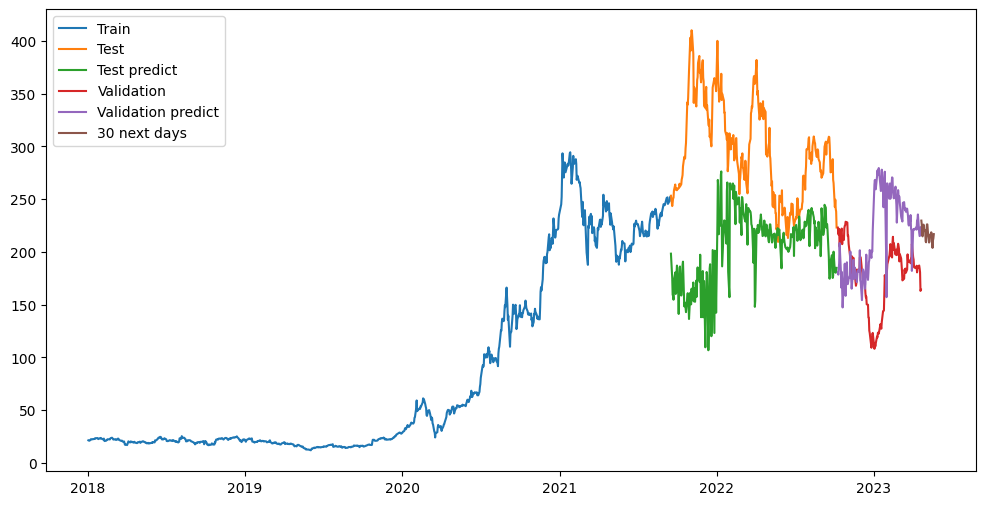

In [68]:
plot_result(df,data)